In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

$$\text{FeatureSelector, NumberSelector, OHEEncoder}$$

In [2]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

$$\text{Business Threshold Calibrate}$$

In [22]:
def business_threshold_calibrate(y_test, y_test_pred, retention_cost = 1, income_cost = 2):
    
    business_threshold = 0
    total_revenue_max = float('-inf')

    rs = []
    n = 100
    for opt_buisness_tr in np.linspace(0, 1, n):
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_test_pred > (opt_buisness_tr))
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        retain_sum = (FP+TP) * retention_cost
        income = TP * income_cost
        total_revenue = income - retain_sum
        
        if total_revenue_max < total_revenue:            
            business_threshold = opt_buisness_tr
            total_revenue_max = total_revenue
            
        rs.append(total_revenue)

    plt.figure(figsize = (10, 7))
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

In [4]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
categorical_columns = ['Geography', 'Gender']
continuous_columns = ['HasCrCard', 'IsActiveMember', 'Tenure', 'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [8]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [10]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']


In [11]:
t_list, f_list, p_list, r_list, roc_list, total = [], [], [], [], [], []

In [12]:
for model in models:
    classifier = Pipeline([('features', feats), ('classifier', eval(model+'(random_state = 42)'))])    
    classifier.fit(X_train, y_train)
    
    y_test_pred = classifier.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
    precision, recall = precision[:-1], recall[:-1]

    nzm_prec = precision != 0
    nzm_rec = recall != 0
    nzm = nzm_prec * nzm_rec

    precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

    fscore = (2 * precision * recall) / (precision + recall)

    ix = np.argmax(fscore)
    t_list.append(thresholds[ix])
    f_list.append(fscore[ix]) 
    p_list.append(precision[ix])
    r_list.append(recall[ix])
    roc_list.append(roc_auc_score(y_test, y_test_pred))
    
    
    cnf_matrix = confusion_matrix(y_test, y_test_pred > thresholds[ix])
    
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    
    retain_sum = FP+TP
    income = TP * 2
    total_revenue = income - retain_sum
    total.append(total_revenue)


results = pd.DataFrame({'Threshold': t_list,
                        'F-score': f_list,
                        'Precision': p_list,
                        'Recall': r_list,
                        'ROC-AUC': roc_list,
                        'Total Revenue': total}, index = models, columns = ['Threshold', 'F-score', 'Precision', 'Recall', 'ROC-AUC', 'Total Revenue'])
results

,Threshold,F-score,Precision,Recall,ROC-AUC,Total Revenue
LogisticRegression,0.198587,0.410256,0.294521,0.675835,0.665668,-481
DecisionTreeClassifier,1.000000,0.519337,0.488735,0.554028,0.702930,0
RandomForestClassifier,0.390000,0.637007,0.656250,0.618861,0.861715,153
GradientBoostingClassifier,0.329990,0.646154,0.632768,0.660118,0.875087,140


* Поработаем дальше с моделью случайного леса, т.к. она имеет наибольшую <b>Precision</b>-метрику и позволяет отбить денег чуть больше, чем <b>GradientBoostingClassifier</b>.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
params = {
    'classifier__n_estimators': np.arange(10, 110, 10),
    'classifier__max_depth': np.arange(5, 20, 5),
    'classifier__min_samples_leaf': np.arange(1, 15, 2)
}

In [15]:
classifier = Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))])
search = GridSearchCV(classifier, n_jobs = -1, param_grid = params, scoring = 'precision', cv = 5)
search.fit(X_train, y_train)
search.best_params_, search.best_score_

({'classifier__max_depth': 5,
  'classifier__min_samples_leaf': 9,
  'classifier__n_estimators': 30},
 0.8934499245789569)

In [23]:
classifier = Pipeline([('features', feats), ('classifier', RandomForestClassifier(max_depth = 5, min_samples_leaf = 9, n_estimators = 30, random_state=42))])
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
precision, recall = precision[:-1], recall[:-1]

nzm_prec = precision != 0
nzm_rec = recall != 0
nzm = nzm_prec * nzm_rec

precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

ml_tr = thresholds[ix]

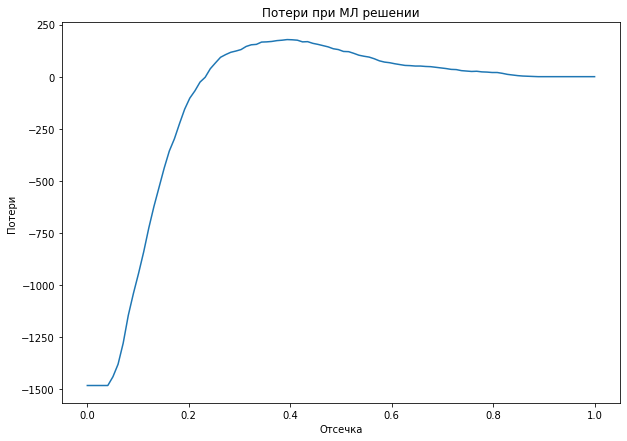

In [24]:
business_tr =  business_threshold_calibrate(y_test, y_test_pred, retention_cost = 1, income_cost = 2)

In [25]:
def report(y_test, y_test_pred, tr, retention_cost = 1, income_cost = 2):
    cnf_matrix = confusion_matrix(y_test, y_test_pred > tr)
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    retain_sum = (FP + TP) * retention_cost
    income = TP * income_cost
    total_revenue = income - retain_sum
    print(f'Отсечка: {tr} \tДоход за вычетом трат: {total_revenue}')
    return 

In [27]:
report(y_test, y_test_pred, ml_tr)
report(y_test, y_test_pred, business_tr)

Отсечка: 0.27834590057330466 	Доход за вычетом трат: 118
Отсечка: 0.393939393939394 	Доход за вычетом трат: 178
